# The best place to rent

Hill: A person visiting Manhattan can find the best neigbourhood for their needs without needing to do research

Using foursquare and travel time this project will group neighboorhods based on venues in that neighboorhod and venues in neighboorhods that are close in travel time

## Configure the notebook

- Load file with secrets
- Set some constants
- Load libraries

The API secrets are not pushed to github. This is handled by placing them in a file named secrets and removing version control from that file.
Since the file is not in the same directory as the notebooks extra code is needed to add the path to the sys search path

The secrets file containts two variables used in the Foursquare API: CLIENT_ID and CLIENT_SECRET
It contains two variables used int the travel time API: APP_ID and API_KEY

In [1]:
import os
project_folder_path = os.path.dirname(os.getcwd())
project_folder_path
import sys
sys.path.insert(0, project_folder_path)

import secrets
print('secrets.py imported')

secrets.py imported


The data path contains data loaded from the net. The sanbox accounts used to load the data have limits on the number of requests. Storing the results allows for restarting the kernal without having to make new calls to the API.

In [2]:
DATA_PATH = project_folder_path + '/data/external/'
print('Data path is :{}'.format(DATA_PATH))
del project_folder_path

Data path is :/Users/danielhaugstvedt/Developer/coursera_capstone/data/external/


Import the standard libraries

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import folium # map rendering library

import pickle # needed to store variables

import time # Try to not overload the traveltime API

from importnb import Notebook # Import notebooks

print('Libraries imported.')

Libraries imported.


## Get neighborhoods in New York which are not in Manhattan 

The dataset with neighborhoods for New York exists for free on the [web](https://geo.nyu.edu/catalog/nyu_2451_34572)

The information on the webpage where the download link is located gave this information for the element to download a geojson file
```
<a class="btn btn-primary btn-block download download-generated" 
   data-download-path="/download/nyu-2451-34572?type=geojson" 
    data-download="trigger" 
    data-download-type="geojson" 
    data-download-id="nyu-2451-34572" href="">Download
</a>
```

Using this information i ran a request. The information from running a request to the URI: `https://geo.nyu.edu/download/nyu-2451-34572?type=geojson` was:

`[['success',
  '<a data-download="trigger" data-download-id="nyu-2451-34572" data-download-type="generated-geojson" href="/download/file/nyu-2451-34572-geojson.json">Your file nyu-2451-34572-geojson.json is ready for download</a>']]`
  
I used this information to run the second request:

In [4]:
file_name = 'nyu-2451-34572-geojson.json'
URI_NY = 'https://geo.nyu.edu/download/file/nyu-2451-34572-geojson.json'

try: 
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'r') as infile:
        ny_json = json.load(infile)
except FileNotFoundError:
    print('Failed to load json from local file, loading from web')
    response_ny = requests.get(URI_NY)
    print(response_ny.status_code, response_ny.reason)
    
    ny_json = response_ny.json()
    with open(DATA_PATH + file_name, 'w') as outfile:
        json.dump(ny_json, outfile)

print('Total number of features in geojsjon: {}'.format(ny_json['totalFeatures']))

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/nyu-2451-34572-geojson.json
Total number of features in geojsjon: 306


Turn the json file into  a data frame

In [5]:
neighborhoods_data = ny_json['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_ny = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods_ny['Borough'].unique()),
        neighborhoods_ny.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Split the data in Manhattan and not Manhattan

If there are Neighborhoods with the same name we only keep the neigbourhood listed first
A second option is to rename them but without local knowledge this could turn out to be allot of work

In [8]:
neighborhoods_not_manhattan = (neighborhoods_ny.loc[neighborhoods_ny['Borough'] != 'Manhattan', 
                                                   ['Neighborhood', 'Latitude', 'Longitude']]
                                               .reset_index(drop=True)
                                               .drop_duplicates(subset = 'Neighborhood'))
neighborhoods_manhattan = (neighborhoods_ny.loc[neighborhoods_ny['Borough'] == 'Manhattan', 
                                               ['Neighborhood', 'Latitude', 'Longitude']]
                                           .reset_index(drop=True)
                                           .drop_duplicates(subset = 'Neighborhood'))

Print som key values from the data frames

In [9]:
print(('The number of neigborhoods in New York' 
       'but not in Manhattan is {}').format(len(neighborhoods_not_manhattan.index)))
print(('The number of neigborhoods in Manhattan is {}').format(len(neighborhoods_manhattan.index)))

The number of neigborhoods in New Yorkbut not in Manhattan is 264
The number of neigborhoods in Manhattan is 40


### Clean up the kernal

The notbook is so long that cleaning up while running it helps

In [10]:
del ny_json
del column_names
del data
del file_name
del neighborhoods_ny 
del neighborhood_lat     
del neighborhood_latlon  
del neighborhood_lon     
del neighborhood_name    
del neighborhoods_data    
del infile
del URI_NY
del borough
print('Cleaned')

Cleaned


## Get the foursquare data for nieghborhoods not in Manhattan

Using the foursquare API, get the venues in New York

In [11]:
neighborhood_latitude = neighborhoods_not_manhattan['Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods_not_manhattan['Longitude'] # neighborhood longitude value
neighborhood_name = neighborhoods_not_manhattan['Neighborhood'] # neighborhood name

Set some global variables to use in the four square API


In [12]:
# We want the real number, not a relative number
# Thereforw we set the limit to be so high that there should never be any venues droped (this is tested)
LIMIT = 500 
VERSION = '20180605' 

Define a function for gettingt nearby venues

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            secrets.CLIENT_ID, 
            secrets.CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results_object = requests.get(url)
        if results_object.status_code != 200:
            print('A request failed with status code: {} and reason: {}'.format(
                    results_object.status_code, 
                    results_object.reason))
            break
        
        results = results_object.json()["response"]['groups'][0]['items']
        print('{} has {} venues'.format(name, len(results)))
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print('makeing a data frame and returning it ')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Check for a file with the data Call the function for getting nearby venues

The distance used is calculated like this
- Average walking speed 5 km/h
- Converted to m/min this is 83.33
- A 5 min walk is **416 m**

In [14]:
radius = 416 # The four square limit parameter uses meters
file_name = 'ny_venues.json'
try:
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'rb') as infile:
        ny_venues = pickle.load(infile)
        print('Sucess loading from file')
except FileNotFoundError:
    print('Failed to load json from local file, trying to load from web')
    ny_venues = getNearbyVenues(neighborhood_name, neighborhood_latitude, neighborhood_longitude, radius)
    with open(DATA_PATH + file_name, 'wb') as outfile:
        pickle.dump(ny_venues, outfile)

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/ny_venues.json
Sucess loading from file


In [15]:
print(ny_venues.shape)
ny_venues.head()

(5193, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896521,-73.844680,Pharmacy
2,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
3,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place
4,Co-op City,40.874294,-73.829939,Sleepy's Co-Op City,40.872234,-73.828607,Mattress Store


### Limit the number of neigboorhods

First we limit it to the results from foursquare. If there are no venues in foursquare we do not need to evaluate the result

In the proof of concept the limit was 20 first neighborhoods. For the final presentation it was set to 100. It is easy to extend this to more neigborhoods later. 262 is the maximum

We did not get all the venues from all the neigborhoods because the API is on a sandbox account
Therefore we need to check which Neighborhood so we can use them in the Travel Time API 

In [16]:
neighborhoods_tmp = pd.DataFrame({'Neighborhood': ny_venues.Neighborhood.unique()}) # make a dataframe with unique values
neighborhoods_foursquare = neighborhoods_not_manhattan.merge(neighborhoods_tmp, how = 'right', on = 'Neighborhood')

In [17]:
neighborhoods_foursquare.shape

(262, 3)

This cell was only needed during the POC
Now that all the data is used it is not needed.

Refactoring code could be an option but the time spent seems too long

In [18]:
n_neighborhoods = 262

neighborhoods_final = neighborhoods_foursquare.iloc[0:n_neighborhoods]

ny_venues_final = ny_venues.merge(
    pd.DataFrame({'Neighborhood': neighborhoods_final.Neighborhood}), 
    how = 'right', 
    on = 'Neighborhood')


In [19]:
print(neighborhoods_final.shape)
print(ny_venues_final.shape)

(262, 3)
(5193, 7)


### Store the values so that the travel time can run a a separate script

In [20]:
file_name = 'neighborhoods_final.p'
with open(DATA_PATH + file_name, 'wb') as outfile:
    pickle.dump(neighborhoods_final, outfile)

In [21]:
file_name = 'ny_venues_final.p'
with open(DATA_PATH + file_name, 'wb') as outfile:
    pickle.dump(ny_venues_final, outfile)

### Clean up the kernal

The notbook is so long that cleaning up while running it helps

In [22]:
del LIMIT
del VERSION
del file_name
del infile
del outfile 
del radius     
del neighborhoods_tmp  
del neighborhoods_not_manhattan     
del neighborhoods_manhattan    
del neighborhoods_foursquare    
del n_neighborhoods
del getNearbyVenues
del ny_venues
del neighborhood_latitude
del neighborhood_longitude
del neighborhood_name
print('Cleaned')

Cleaned


## Get the travel time between the different neighborhoods

Using the traveltime API, get the travel time between the different neighborhoods

This has been moved to a new notebook. The reason is that the API was returning too manu requests. This was handled by saving the results, rewritin ghte code. Waiting for some thime and then run the new code. This means the code is ugly.

Refactoring would take too much time

**Warning** the variables used in the imported notebook which I do not intend to use in this notebook are deleted. THis means some variables in this notbook could disapear if the name is wrong. The imported notwbook would have changed their value anyway, so this is safer. Using a naming scheme like ending varialbenames with _ is too much work. The point of this hack is to save time

In [23]:
with Notebook(): 
        import travel_time

secrets.py imported
Data path is :/Users/danielhaugstvedt/Developer/coursera_capstone/data/external/
Libraries imported.
We need less than 2000 locations. The number we are using is 262
Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_0_149.p
Sucess loading from file
150
150
Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_150_192.p
Sucess loading from file
43
43
Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_193_260.p
Sucess loading from file
68
68
Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_261.p
Sucess loading from file
1


In [24]:
travel_time_df = travel_time.travel_time_df

### Clean up the kernal

The notbook is so long that cleaning up while running it helps

In [25]:
del travel_time
print('Cleaned')

Cleaned


## Describe the neighborhoods using the pricipal components analysis

Tested approches:

- Fit PCA to local venues first and extract the two pricipal components (PC). Use the same components on the venues that are weighted with travel

- Fit a separate PCA to both the local venues and the venues weighted with local venues (This is the one presented)

- Merge the data and run a PCA on the combined information

Untested:
- Sum the local and the venues that er weighted with travel. This has not been tested. This is becuse most of the value proposition is from telling a nerative. Beeing able to seperate the two factors seems really important.

### Prep the data

There are two datasets, the first is the local venues. It is made in to steps
- Make one hot encoding of the venues
- Sum the venues from each cite

The second dataset is the weighted sum of the venues from other neighborhoods. The weight is inverse proportional to the number of hurs

Make the local dataset

In [26]:
ny_onehot = pd.get_dummies(ny_venues_final[['Venue Category']], prefix="", prefix_sep="", dtype = 'float')
ny_onehot['Neighborhood'] = ny_venues_final['Neighborhood']
local_venues_df = ny_onehot.groupby('Neighborhood').agg('sum')

Make the travel dataset (weigted sum)

In [27]:
travel_venues_df = travel_time_df.dot(local_venues_df)  

In [28]:
print(local_venues_df.shape, travel_venues_df.shape, travel_time_df.shape)

(262, 353) (262, 353) (262, 262)


In [29]:
### Do PCA on the local venues dataset

In [30]:
# standarize the data
x = StandardScaler().fit_transform(local_venues_df.values) 

pca = PCA(n_components=2)
pca.fit(x)

# Get the PC of the local
principalComponents = pca.transform(x)
principalDf = pd.DataFrame(
    data = principalComponents, 
    columns = ['principal component 1', 'principal component 2'],
    index = local_venues_df.index)

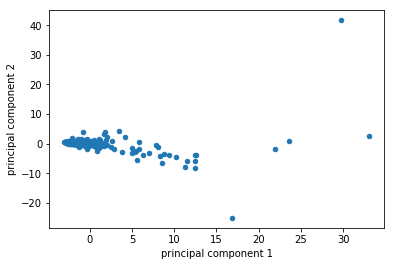

In [31]:
%matplotlib inline

principalDf.plot.scatter(x='principal component 1',y='principal component 2')

The four outliers really hurt the PCA. Removing them might make it easier to see how the other neighborhoods behave 

In [32]:
special_neighborhoods = principalDf.loc[principalDf['principal component 1']>15,:]
print(special_neighborhoods.index)
special_neighborhoods_df = local_venues_df.loc[special_neighborhoods.index,:]
special_neighborhoods_df.sum(axis=1)

Index(['Carroll Gardens', 'Downtown', 'Greenpoint', 'North Side',
       'South Side'],
      dtype='object', name='Neighborhood')


Neighborhood
Carroll Gardens     90.0
Downtown           100.0
Greenpoint         100.0
North Side         100.0
South Side         100.0
dtype: float64

They all have close to a 100 venues. 4 hava exactly a 100 venues. The later is due to the PAI and the sandbokx account.

Exluding them from the data (they could be used with the Manhattan data instead) should result in results that makes more sence

In [33]:
is_special = local_venues_df.index.isin(special_neighborhoods.index)
local_venues_clean_df = local_venues_df[~is_special]

In [34]:
# standarize the data
x_clean = StandardScaler().fit_transform(local_venues_clean_df.values) 

pca1 = PCA(n_components=2)
pca1.fit(x_clean)

# Get the PC of the local
principalComponents_clean = pca1.transform(x_clean)
principalDf_clean = pd.DataFrame(data = principalComponents_clean
             , columns = ['principal component 1', 'principal component 2'])

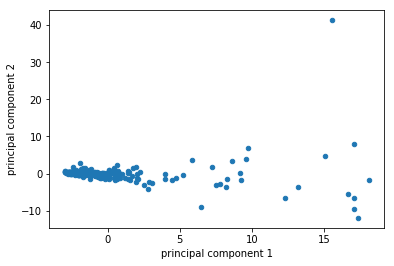

In [35]:
principalDf_clean.plot.scatter(x='principal component 1', y='principal component 2')

It looks better, There is one new outlier. Looking at the amount of variance explained tells us more.

In [36]:
print(('The two first principal components explain {:.1%} of '
      'the variance in the local data').format(
    sum(pca.explained_variance_ratio_)
    ))
print(('The two first principal components explain {:.1%} of '
      'the variance in the cleaned local data').format(
    sum(pca1.explained_variance_ratio_)
    ))

The two first principal components explain 9.6% of the variance in the local data
The two first principal components explain 7.8% of the variance in the cleaned local data


The PCA was not that sucessfull. The large number of zeros in the data and the high number of venu types makes this a problem where PCA seems to come up a bit short.

Switching to a simple count of the number of venues might be just as good as the PCA. 

**Attribute 1: Busy**

The first atribute is the total number of venues in the neighborhood. This variable will be names busy. It seems like a fair name and it is easy to understand. 

### Travel data PCA

The travel data is a weighted combination of the venues which you can get to with public transport.

The venues removed becouse they are super busy are included in the values. This means you are allowd to travel to them. They are excluded from the PCA. A neighborhood needs local information to be interesting

A possible imporvment is to also includ the venues from Manhattan. These are all super busy and the numbers are probably wrong as they have 100+ venues. Before improving the data we should explore what can be done with the current data. 



In [37]:
is_special = travel_venues_df.index.isin(special_neighborhoods.index)
travel_venues_clean_df = travel_venues_df[~is_special]

In [38]:
x_travel = StandardScaler().fit_transform(travel_venues_clean_df.values) 

pca2 = PCA(n_components=2)
pca2.fit(x_travel)

principalComponents_travel = pca2.transform(x_travel)
principalDf_travel = pd.DataFrame(
    data = principalComponents_travel, 
    columns = ['principal component 1', 'principal component 2'])

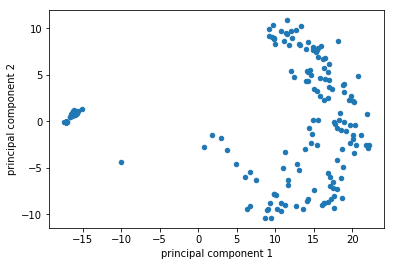

In [39]:
principalDf_travel.plot.scatter(x='principal component 1', y='principal component 2')

In [40]:
print(('The two first principal components explain {:.1%} % of '
      'the variance in the travel data').format(
    sum(pca2.explained_variance_ratio_ )
    ))

The two first principal components explain 81.2% % of the variance in the travel data


It looks like the PCA worked very well on the travel data. They could most likely be used to tell a story which will make sence to users. 

### Understanding the PCs of the travel data

The final step is to check what the two components means

A histogram of the values in the principal component is a good start. We start with the first PC

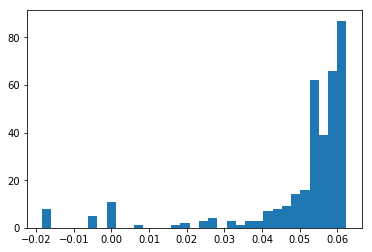

In [41]:
plt.hist(pca2.components_[0], bins='auto')  # arguments are passed to np.histogram
plt.show()

**Atribute 2: Connectivity**

The first PC from the travel dataset is names COnnectivity. Most of the values from component 1 are between 0.05 and 0.06. This means a high value for PC 1 is thae same as having many venues reachable fast with public transport. 

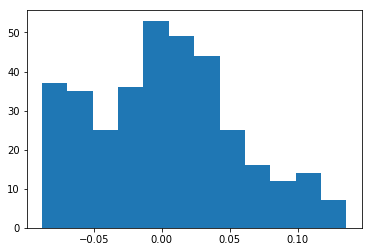

In [42]:
plt.hist(pca2.components_[1], bins='auto')  # arguments are passed to np.histogram
plt.show()

There are a continuum of values for PC 2. Looking at the once that are above 0.10 and below -0.5 might give some clue to what name should be used for the feature

In [43]:
travel_venues_clean_df.iloc[:, pca2.components_[1] > 0.10].columns

Index(['Automotive Shop', 'Baseball Stadium', 'Beach', 'Beach Bar',
       'Bed & Breakfast', 'Board Shop', 'Building', 'Bus Line',
       'Construction & Landscaping', 'Farm', 'Golf Course', 'Home Service',
       'Paella Restaurant', 'Road', 'Sake Bar', 'Skating Rink', 'Smoke Shop',
       'Surf Spot', 'Varenyky restaurant'],
      dtype='object')

Looking at these i get a fealing of being in California. Even more than that I get the fealing of beeing outside a city center.  

In [44]:
travel_venues_clean_df.iloc[:, pca2.components_[1] < -0.07].columns

Index(['Adult Boutique', 'Arts & Entertainment', 'Baby Store', 'Beer Bar',
       'Bike Shop', 'Boxing Gym', 'Climbing Gym', 'College Quad', 'Comic Shop',
       'Coworking Space', 'Creperie', 'Cycle Studio', 'Ethiopian Restaurant',
       'Gaming Cafe', 'Garden', 'Garden Center', 'Hawaiian Restaurant',
       'History Museum', 'Israeli Restaurant', 'Jewelry Store',
       'Kebab Restaurant', 'Lebanese Restaurant', 'Mac & Cheese Joint',
       'Massage Studio', 'Movie Theater', 'Music Store', 'Newsstand',
       'Pakistani Restaurant', 'Piercing Parlor', 'Poke Place',
       'Residential Building (Apartment / Condo)', 'Speakeasy', 'Tennis Court',
       'Theme Park Ride / Attraction', 'Tiki Bar', 'Wine Bar'],
      dtype='object')

Looking at these i get a feeling of being in New York. Even more than that I get the fealing of beeing inside a city center. 

**Atribute 3: Urban**

Transforming the PC2 by simply changing the sign it seems to fit the name urban. This makes it possible to havw some place urban but not busy which sounds cool.

### Clean up the kernal

The notbook is so long that cleaning up while running it helps

In [45]:
del pca
del pca1
del pca2
del ny_onehot
del ny_venues_final
del local_venues_df 
del neighborhoods_final
del principalComponents
del principalComponents_clean
del principalComponents_travel
del principalDf
del principalDf_clean
del travel_time_df
del travel_venues_clean_df
del travel_venues_df
del x
del x_clean
del x_travel
del special_neighborhoods
del special_neighborhoods_df

print('Cleaned')

Cleaned


## Add the three atributes to the venues

Busy, Urban and Connected are the tree atributes we will provide users with. 

Increasing accuracy of the features and adding new attributes are a long term goal but the need for Data Science is no longer pivotal to the progress. A front end whcih can be used etc. is needed to make a minimal viable product. When that is done, more effort should be put on improving the quality and the number of atributes.

In [64]:
attribute_one = local_venues_clean_df.sum(axis = 1).to_frame()

attribute_two_three = principalDf_travel.copy()
attribute_two_three.index = attribute_one.index
attribute_two_three['principal component 2'] = -attribute_two_three['principal component 2']
attributes = pd.merge(attribute_one, attribute_two_three, 
                      how='inner', on='Neighborhood')

Now we set the column names

In [65]:
attributes.columns = ['Busy', 'Connected', 'Urban']

## Visualize the neighborhoods in a map 

Use the geocoding from travel time to get longetiude and altitude of Central Park in New York

Use the longitude and latitude to make a map of manhattan

Add labels for every neigbouthoods into the manhattan map

In [ ]:
query = 'Murray Hill, New York'
URI_traveltime = 'HTTPS://api.traveltimeapp.com/v4/geocoding/search?query={}'.format(query)
print('URI is : {}'.format(URI_traveltime))
headers = {'Host': 'api.traveltimeapp.com',
           'Accept': 'application/json', 
           'X-Application-Id': secrets.APP_ID, # APP ID is in separate file not under version control
           'X-Api-Key': secrets.API_KEY} # API_KEY is in separate file not under version control
result = requests.get(URI_traveltime, headers=headers)
print(result.status_code, result.reason)

In [ ]:
new_york_location_data = result.json()['features'][0]
[longitude, latitude] = new_york_location_data['geometry']['coordinates']
print(longitude, latitude)

In [ ]:
# create map of Manhattan using latitude and longitude values
map_new_york = folium.Map(location=[latitude, longitude], zoom_start=11)

locations = neighborhoods_final.loc[:, 'Neighborhood']
latitudes = neighborhoods_final.loc[:, 'Latitude']
longitudes = neighborhoods_final.loc[:, 'Longitude']

# add markers to map
for lat, lng, label in zip(latitudes, longitudes, locations):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_new_york)  
map_new_york